In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/africa-economic-banking-and-systemic-crisis-data/african_crises.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing

In [3]:
df =  pd.read_csv('/kaggle/input/africa-economic-banking-and-systemic-crisis-data/african_crises.csv')

* Checking top 10 rows for of the dataset

In [4]:
df.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


According to below codes we don't have null values in our dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 14 columns):
case                               1059 non-null int64
cc3                                1059 non-null object
country                            1059 non-null object
year                               1059 non-null int64
systemic_crisis                    1059 non-null int64
exch_usd                           1059 non-null float64
domestic_debt_in_default           1059 non-null int64
sovereign_external_debt_default    1059 non-null int64
gdp_weighted_default               1059 non-null float64
inflation_annual_cpi               1059 non-null float64
independence                       1059 non-null int64
currency_crises                    1059 non-null int64
inflation_crises                   1059 non-null int64
banking_crisis                     1059 non-null object
dtypes: float64(3), int64(8), object(3)
memory usage: 116.0+ KB


In [6]:
df[pd.isnull(df).any(axis=1)]

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis


Now it's usefull to check for unique values within every column in order to see columns just with 0,1 values 

In [7]:
df.nunique().sort_values()

systemic_crisis                       2
domestic_debt_in_default              2
sovereign_external_debt_default       2
independence                          2
inflation_crises                      2
banking_crisis                        2
currency_crises                       3
gdp_weighted_default                  6
case                                 13
cc3                                  13
country                              13
year                                155
exch_usd                            772
inflation_annual_cpi               1022
dtype: int64

With regards to values in the columns, none of the numeric columns needs to be converted into categorical only the banking_crisis.

In [8]:
df['banking_crisis'] = df['banking_crisis'] .apply(lambda x: 1 if x == 'crisis' else 0)

In [9]:
df.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


**Exploratory data analysis**

First we should look on the overall crisis 'occurence' in African states. It hit Africa strongly 3 times before 1970. Since 1970 the crises have started and were occuring repeatedly, hitting hardest around 1990s.

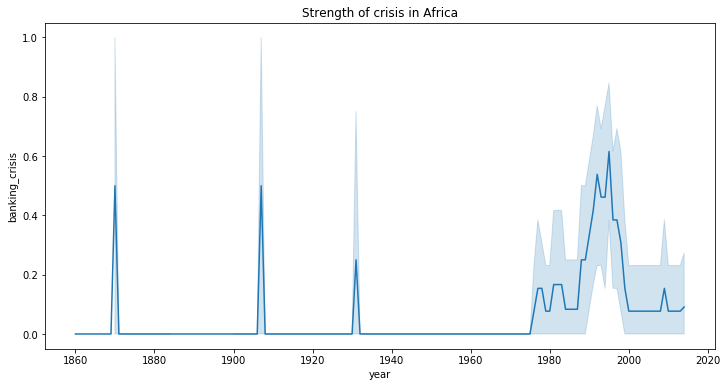

In [10]:
def_palette = sns.color_palette()
cat_palette = sns.color_palette("hls", 16)
fig, ax = plt.subplots(figsize = (12,6)) 
fig = sns.lineplot(x='year', y='banking_crisis', data=df, palette=cat_palette, ax=ax).set_title('Strength of crisis in Africa')


Distribution of continuous columns

In [11]:
con_columns = ['exch_usd','inflation_annual_cpi'] #columns with continuous variables

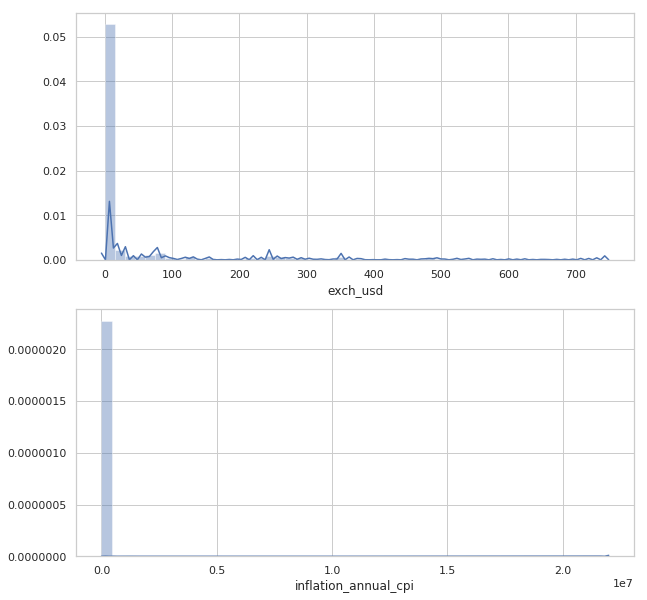

In [12]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,10))
count = 1

for col in con_columns:
    plt.subplot(2,1,count)
    count += 1
    sns.distplot(df[col])

We see an inclination of values towards 0 which can eventually provide incorrect information about dataset. This we can remove by taking values (outliers) within first and third quantile (removing minimum and maximum values).

In [13]:
q1 = df[con_columns].quantile(0.25)
q3 = df[con_columns].quantile(0.75)
iqr = q3 - q1

df[con_columns] = df[con_columns].clip(q1 - 1.5*iqr, q3 + 1.5*iqr, axis=1)

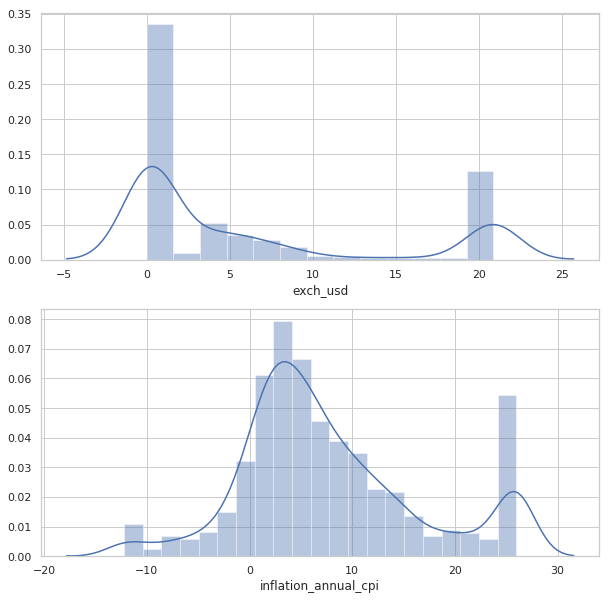

In [14]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,10))
count = 1

for col in df[con_columns]:
    plt.subplot(2,1,count)
    count += 1
    sns.distplot(df[col])

The data are still skewed but the range of y axis has improved. 

First hint on number of crises in individual African countries

In [15]:
df.groupby(['country', 'banking_crisis']).size().sort_values(ascending=False)

country                   banking_crisis
Egypt                     0                 144
South Africa              0                 111
Algeria                   0                  81
Zimbabwe                  0                  75
Morocco                   0                  73
Angola                    0                  70
Tunisia                   0                  70
Zambia                    0                  68
Mauritius                 0                  67
Ivory Coast               0                  59
Kenya                     0                  59
Nigeria                   0                  49
Central African Republic  0                  39
                          1                  19
Zimbabwe                  1                  15
Nigeria                   1                  11
Egypt                     1                  11
Kenya                     1                   8
Angola                    1                   7
Tunisia                   1                   5

Is there any pattern in trend lines for countries and their exchange rate/inflation when banking crisis occur? There seems to be no strong evidence when looking at the visuals below.

In [16]:
individual_countries = list(df['country'].unique())

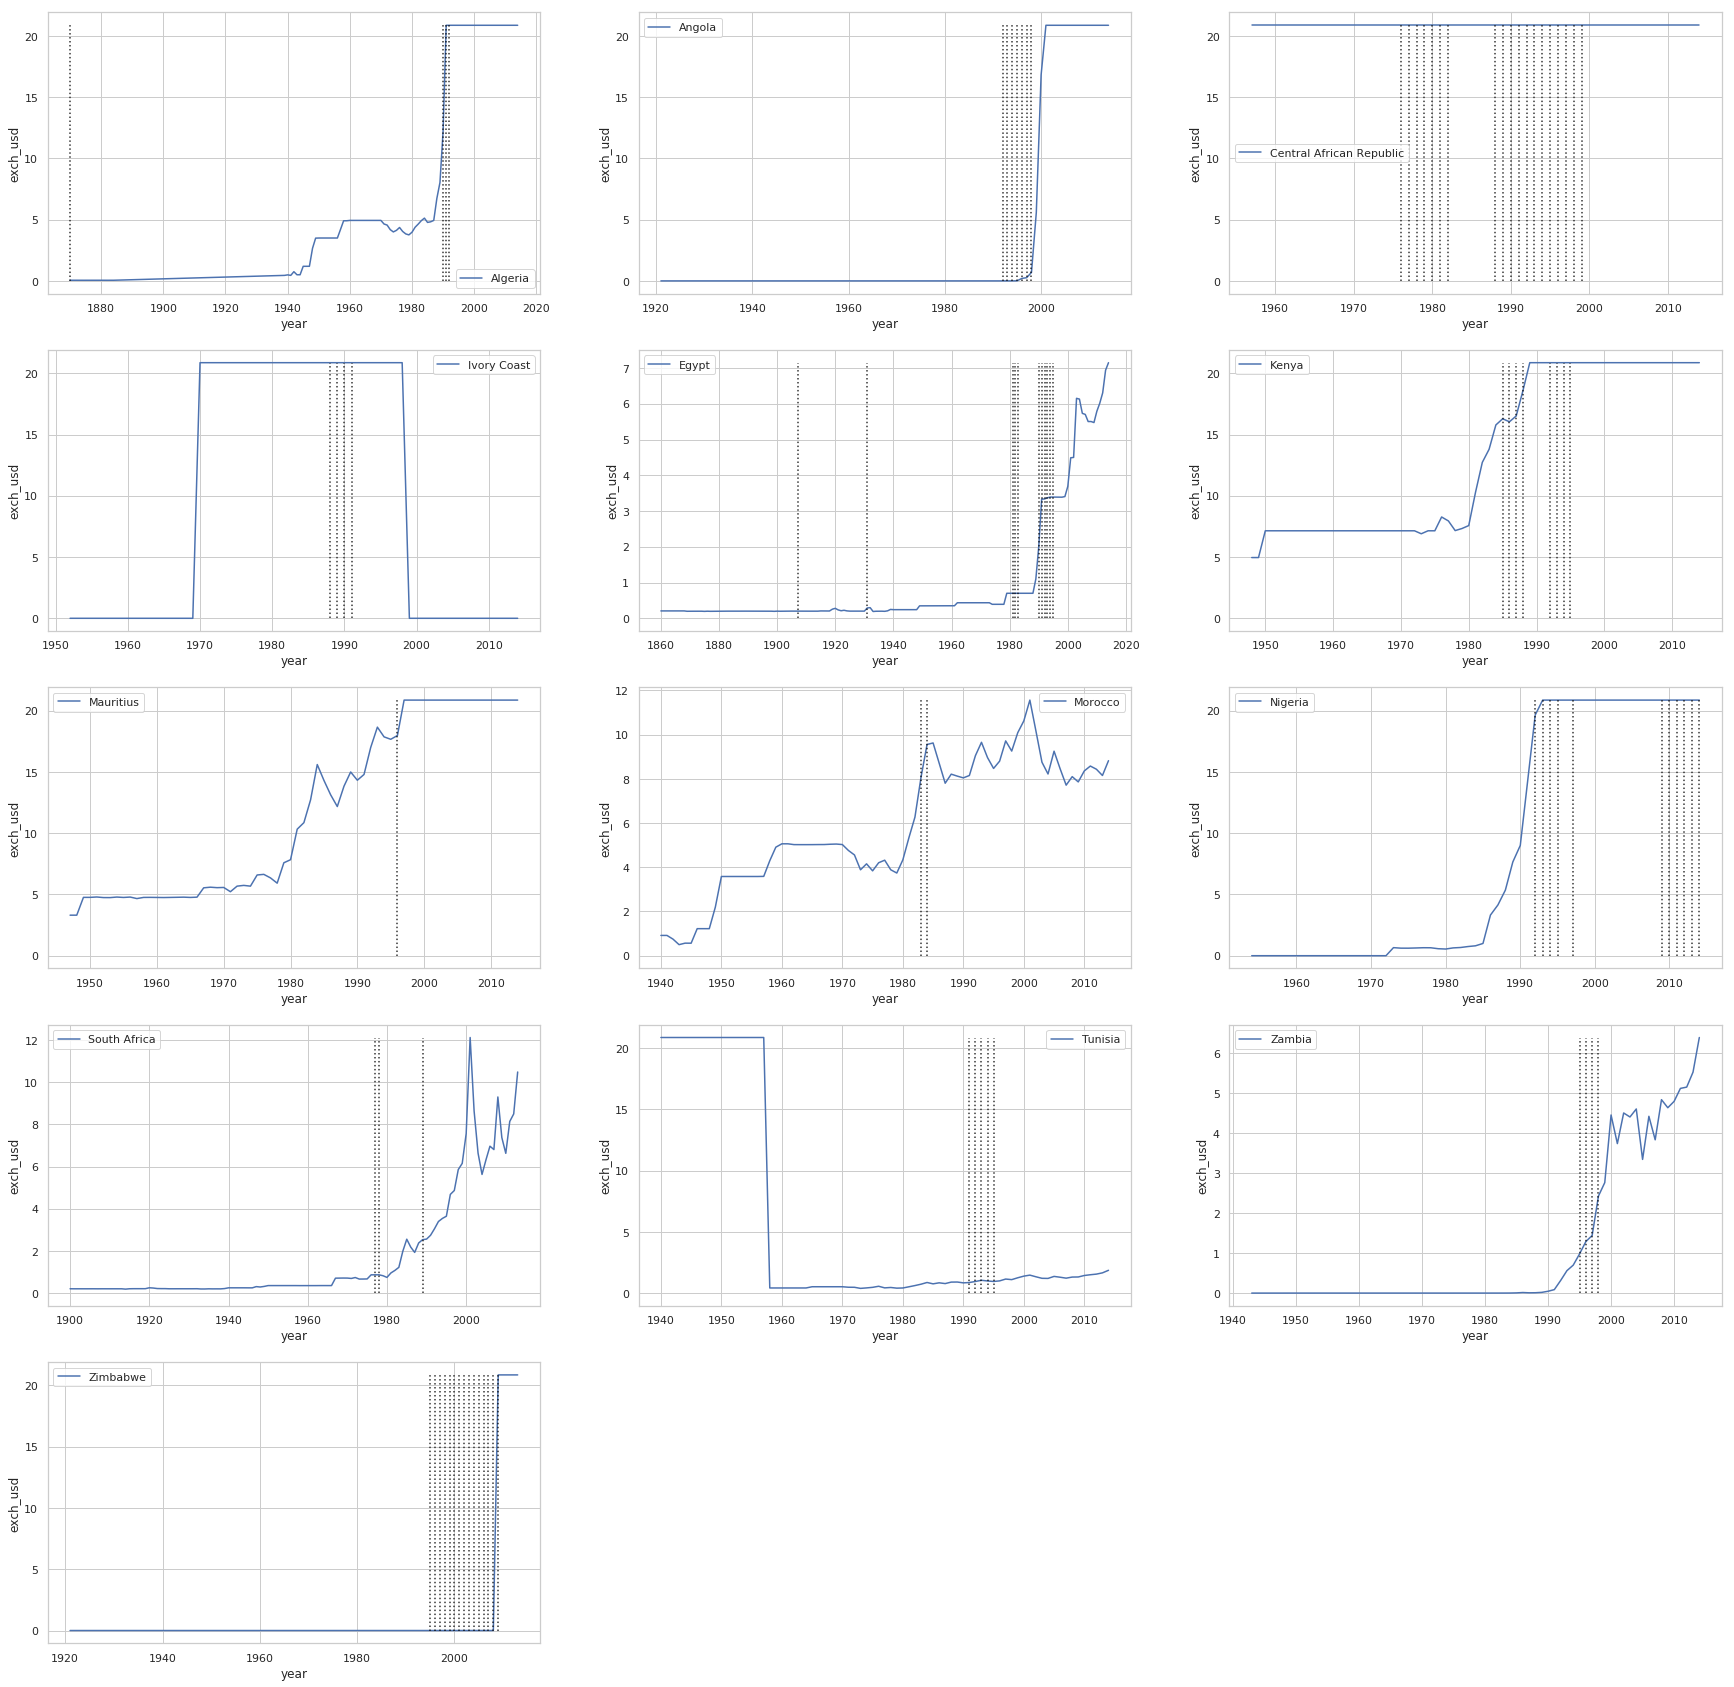

In [17]:
sns.set(style='whitegrid')
plt.figure(figsize=(30,30))

count = 1

for country in individual_countries:
    plt.subplot(5,3,count)
    count+=1
    
    sns.lineplot(df[df.country==country]['year'],
                 df[df.country==country]['exch_usd'],
                 label=country)              
            
    plt.plot([(df[np.logical_and(df.country==country,df.banking_crisis==1)]['year'].unique()),
                  (df[np.logical_and(df.country==country,df.banking_crisis==1)]['year']).unique()],
                 [0,np.max(df[df.country==country]['exch_usd'])],
                 color='black',
                 linestyle='dotted',
                 alpha = 0.8)    
    

Does indepedence have an effect on inflaction and exchange rate? This also doesn't seem to be the case. 

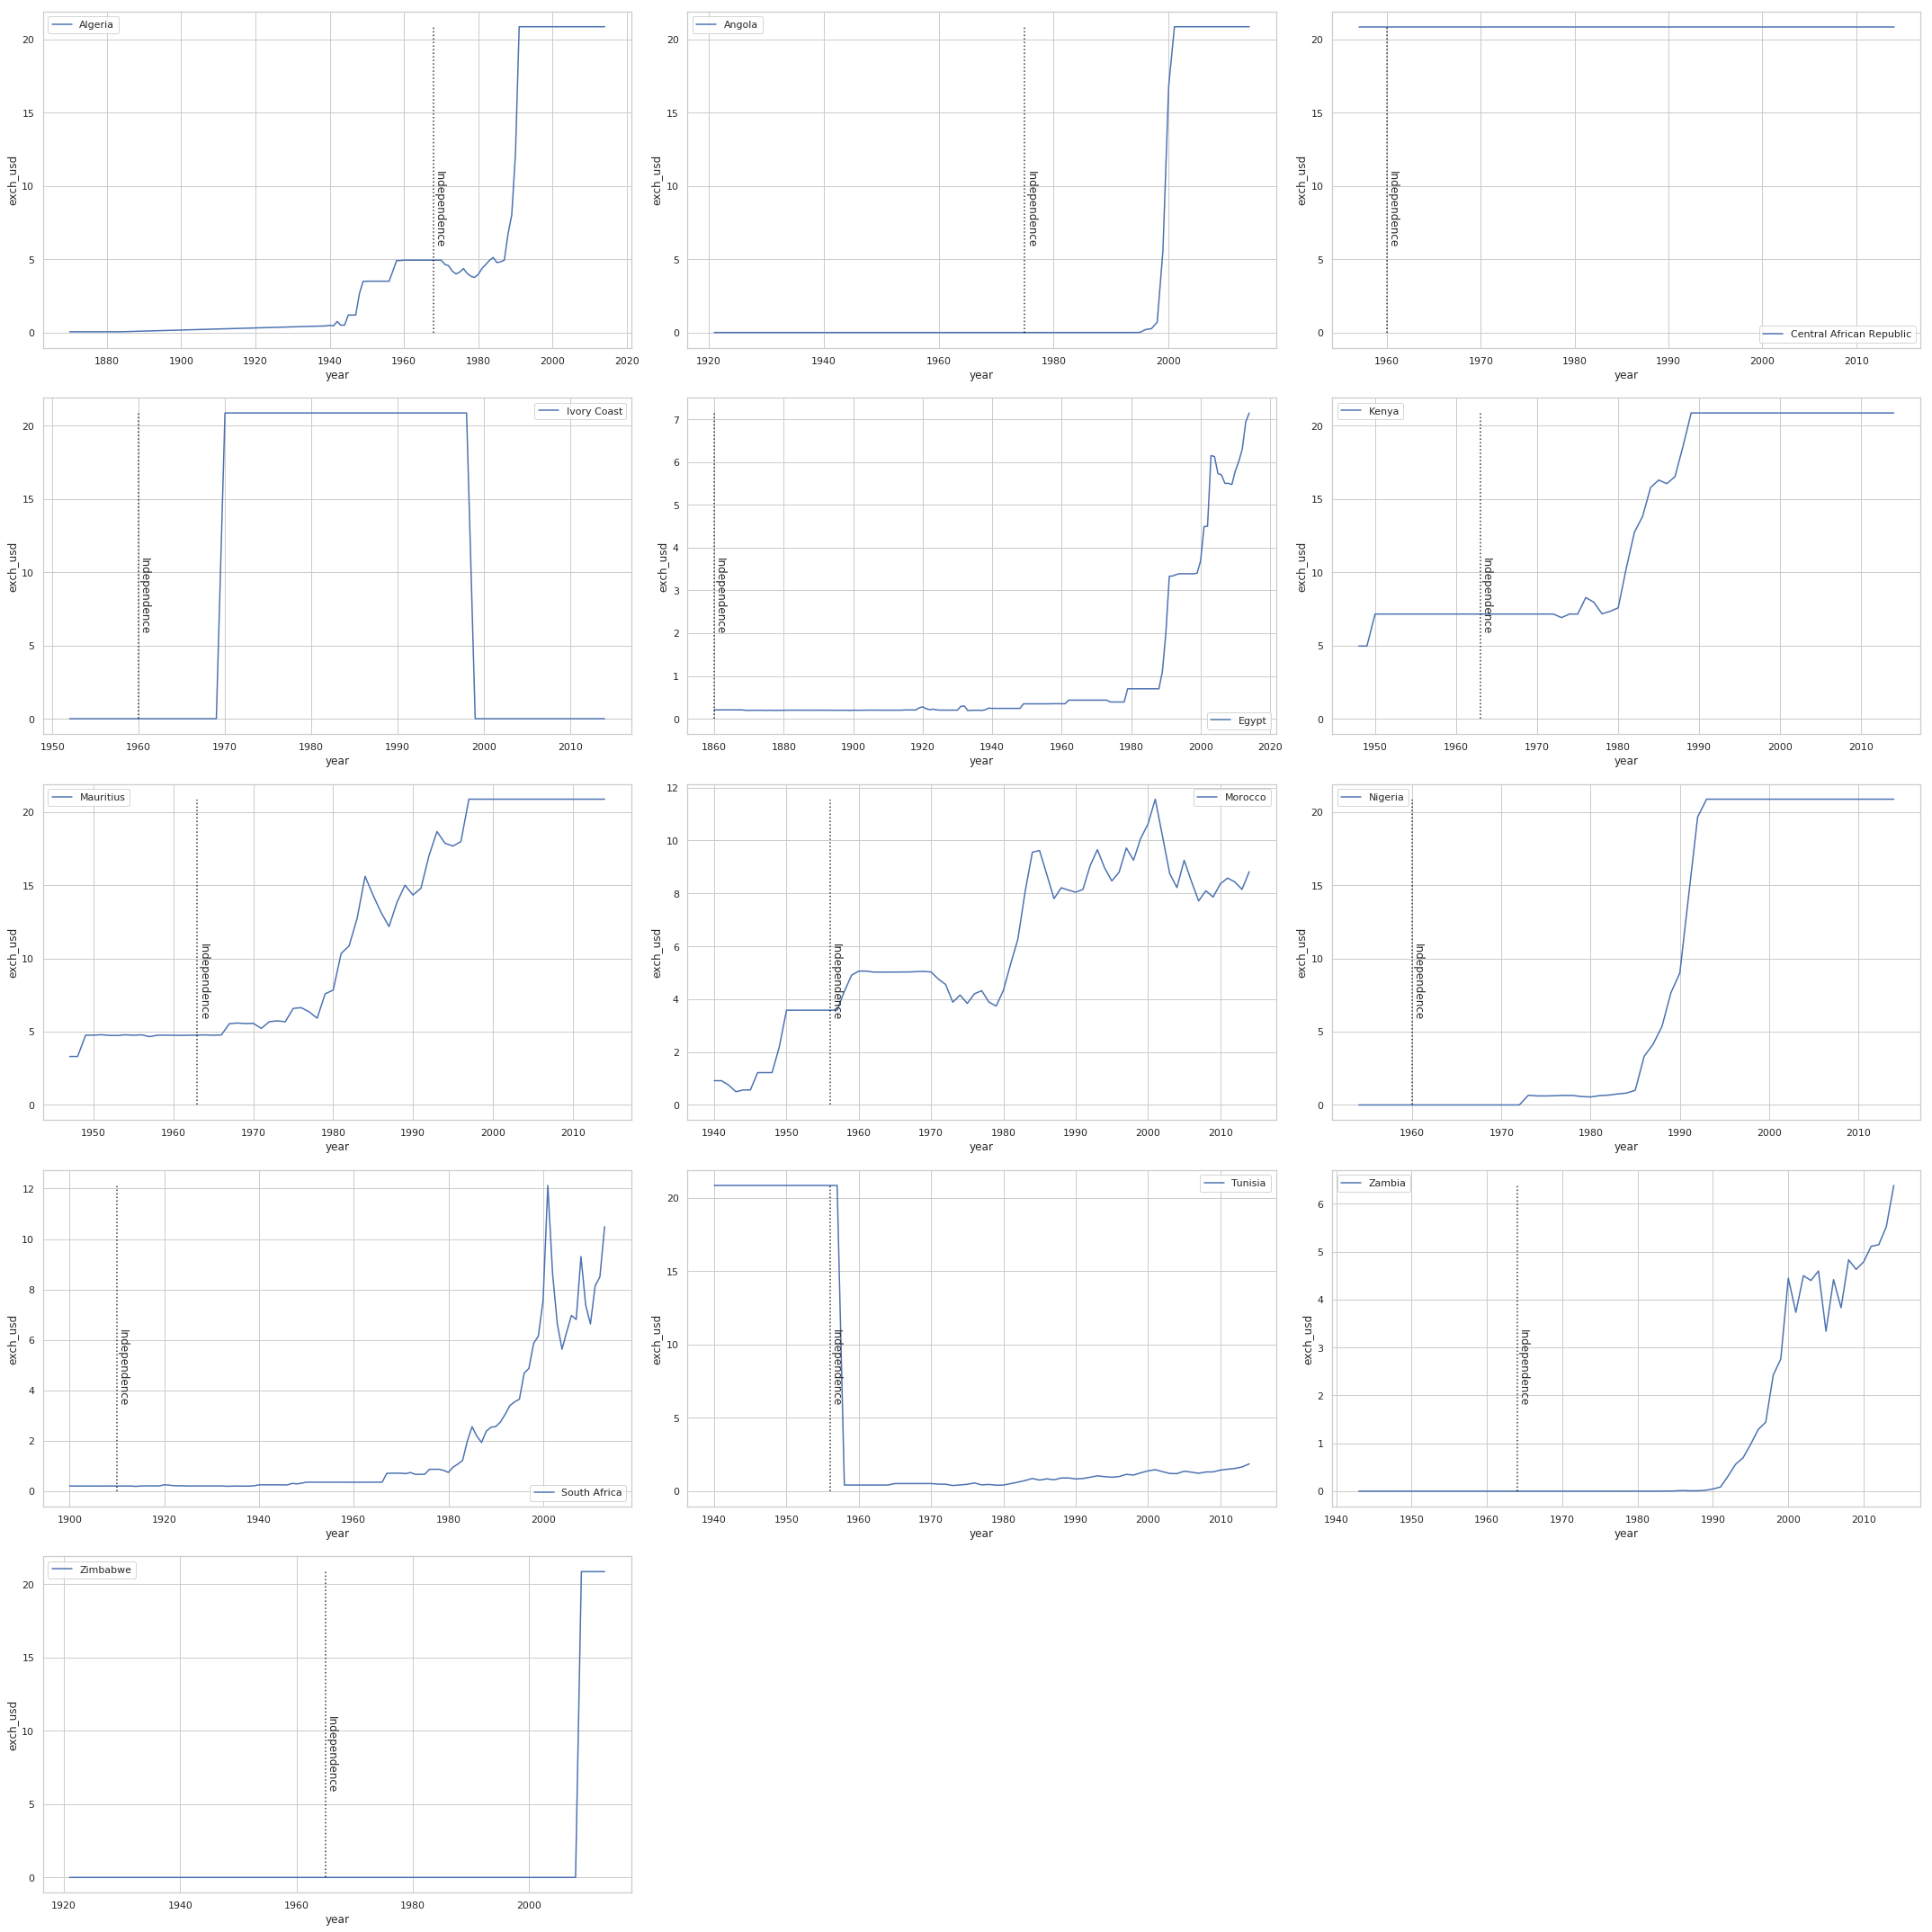

In [18]:
sns.set(style='whitegrid')
plt.figure(figsize=(30,30))
count = 1

for country in individual_countries:
    plt.subplot(5,3,count)
    count+=1
    
    sns.lineplot(df[df.country==country]['year'],
                 df[df.country==country]['exch_usd'],
                 label=country)
                 
  
    plt.plot([np.min(df[np.logical_and(df.country==country,df.independence==1)]['year']),
              np.min(df[np.logical_and(df.country==country,df.independence==1)]['year'])],
             [0,
              np.max(df[df.country==country]['exch_usd'])],
             color='black',
             linestyle='dotted',
             alpha=0.8)
    plt.text(np.min(df[np.logical_and(df.country==country,df.independence==1)]['year']),np.max(df[df.country==country]['exch_usd'])/2,
             'Independence',
             rotation=-90)

    
   
    plt.tight_layout()

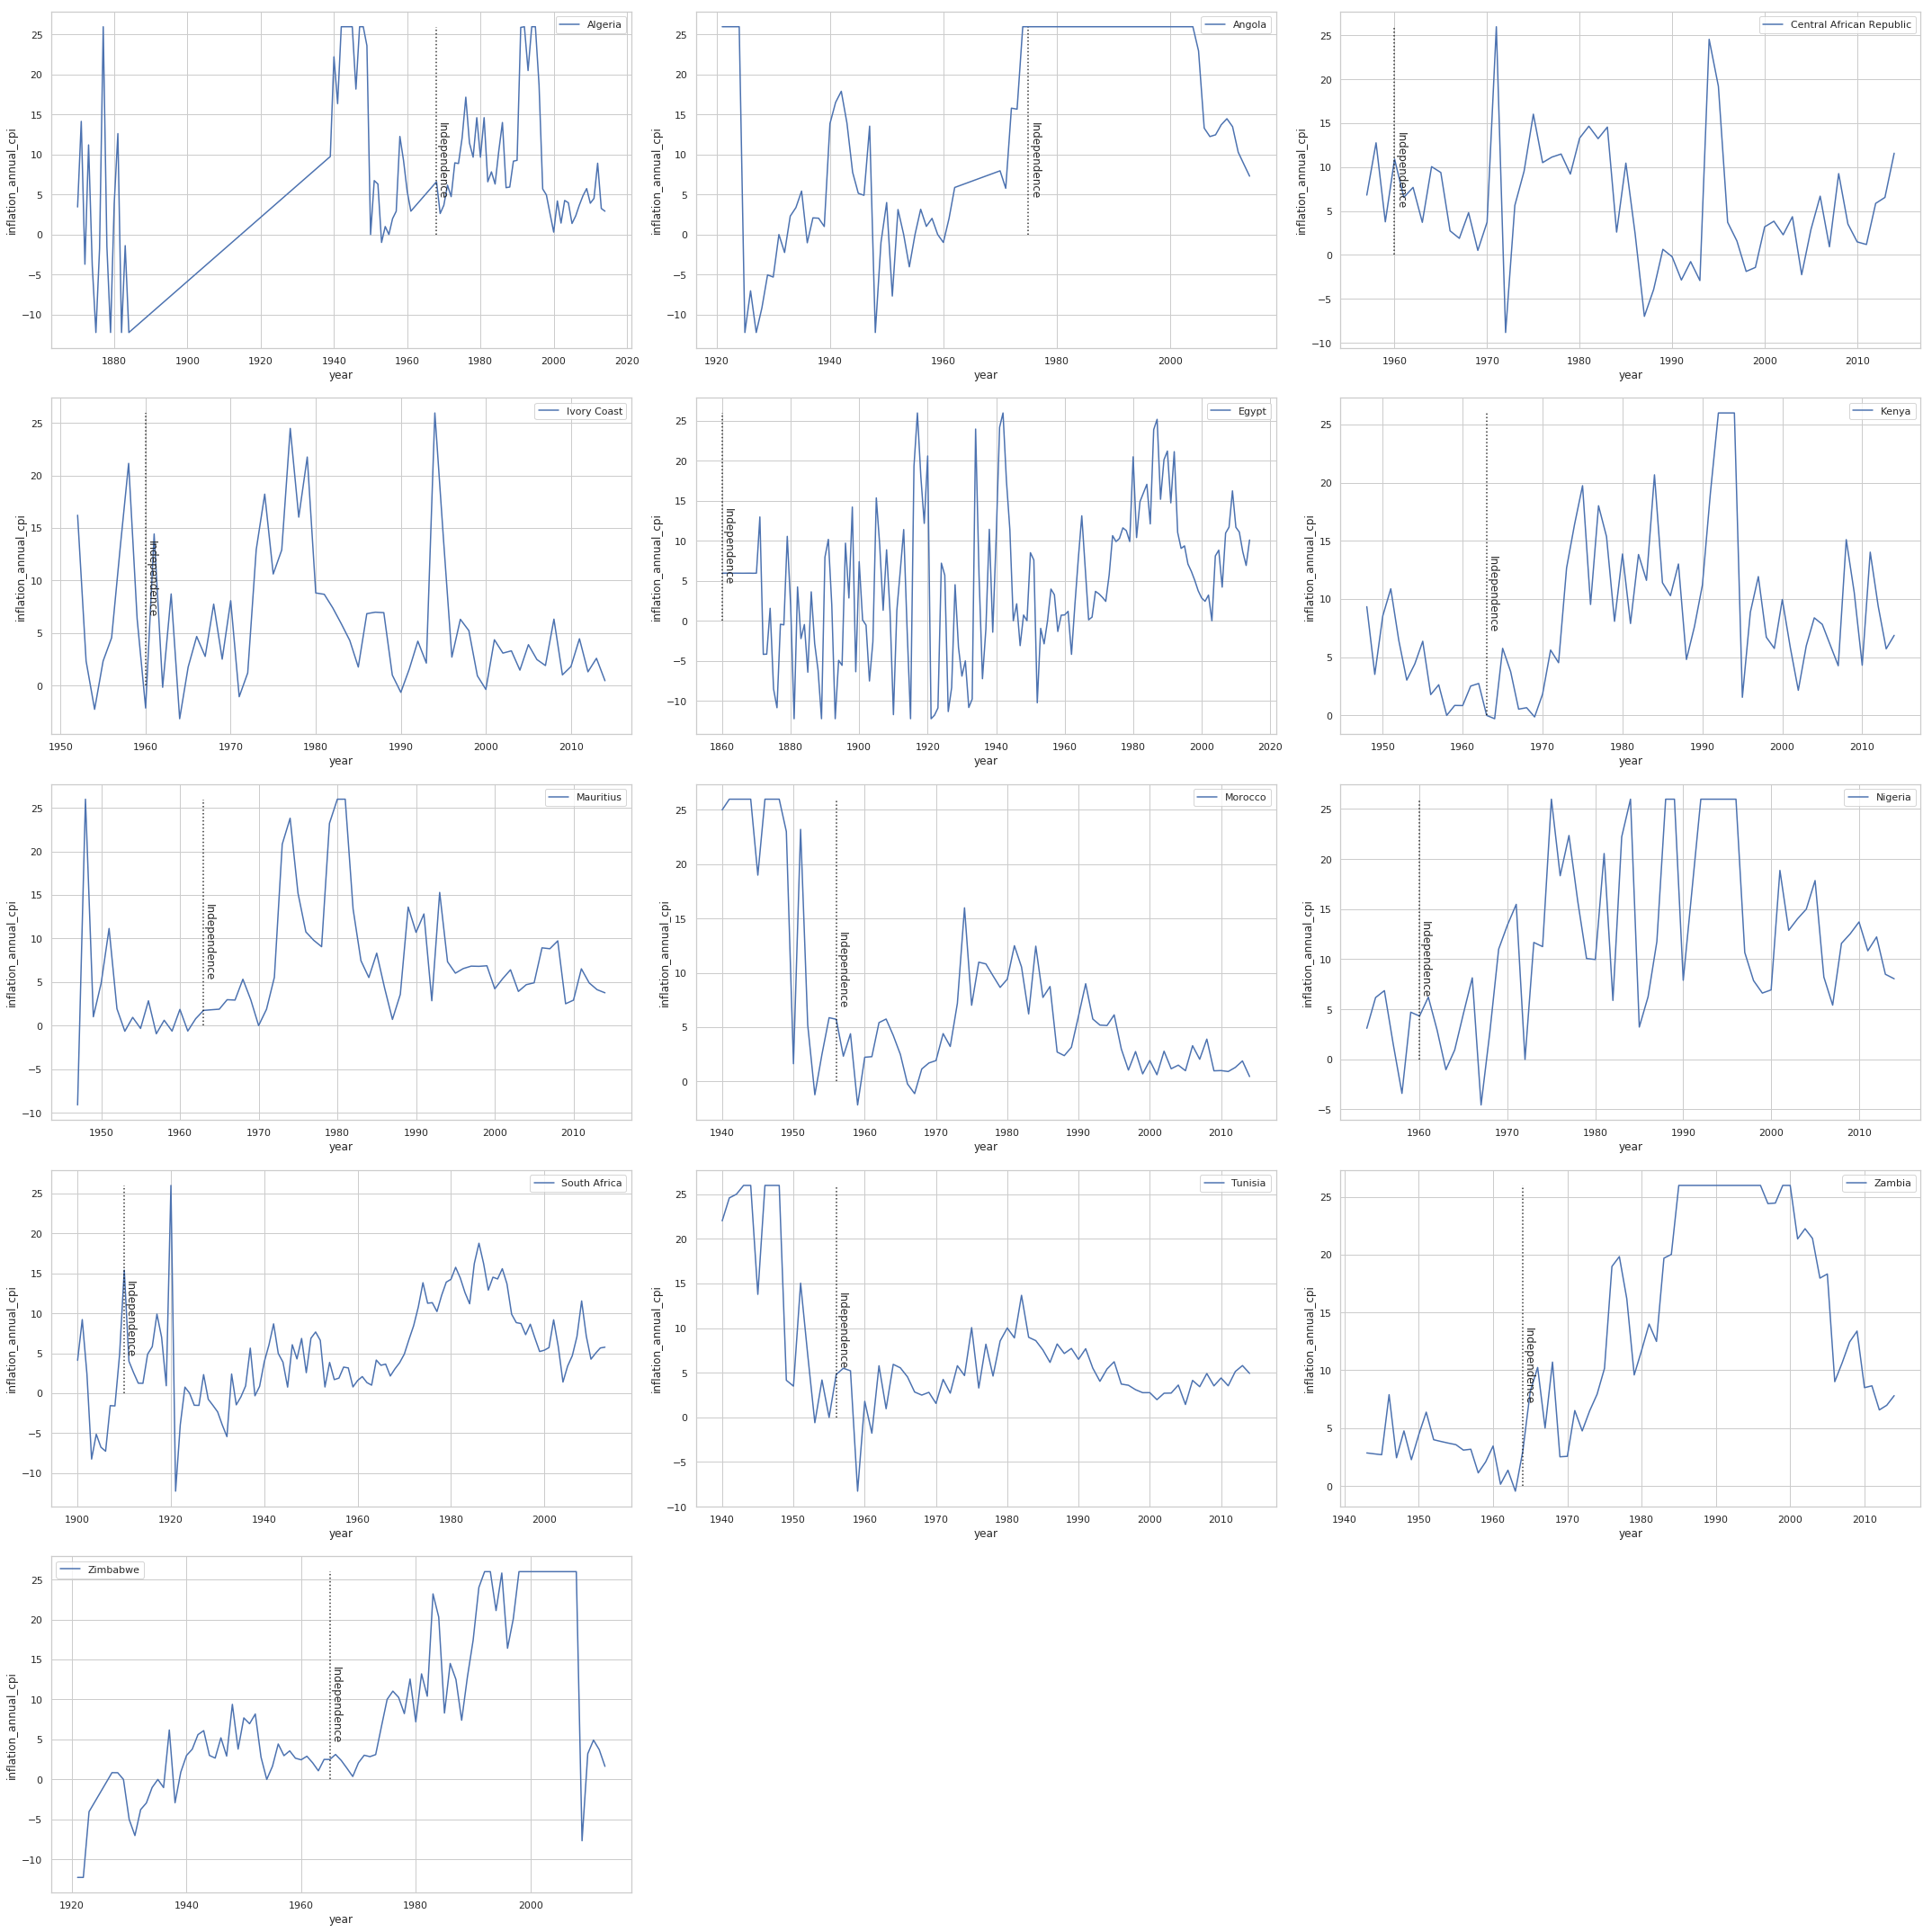

In [19]:
sns.set(style='whitegrid')
plt.figure(figsize=(30,30))
count = 1

for country in individual_countries:
    plt.subplot(5,3,count)
    count+=1
    
    sns.lineplot(df[df.country==country]['year'],
                 df[df.country==country]['inflation_annual_cpi'],
                 label=country)
                 
  
    plt.plot([np.min(df[np.logical_and(df.country==country,df.independence==1)]['year']),
              np.min(df[np.logical_and(df.country==country,df.independence==1)]['year'])],
             [0,
              np.max(df[df.country==country]['inflation_annual_cpi'])],
             color='black',
             linestyle='dotted',
             alpha=0.8)
    plt.text(np.min(df[np.logical_and(df.country==country,df.independence==1)]['year']),np.max(df[df.country==country]['inflation_annual_cpi'])/2,
             'Independence',
             rotation=-90)

    
   
    plt.tight_layout()

Looking closer at number of events (occured vs. not-occured) in binary columns when country faced banking crisis.

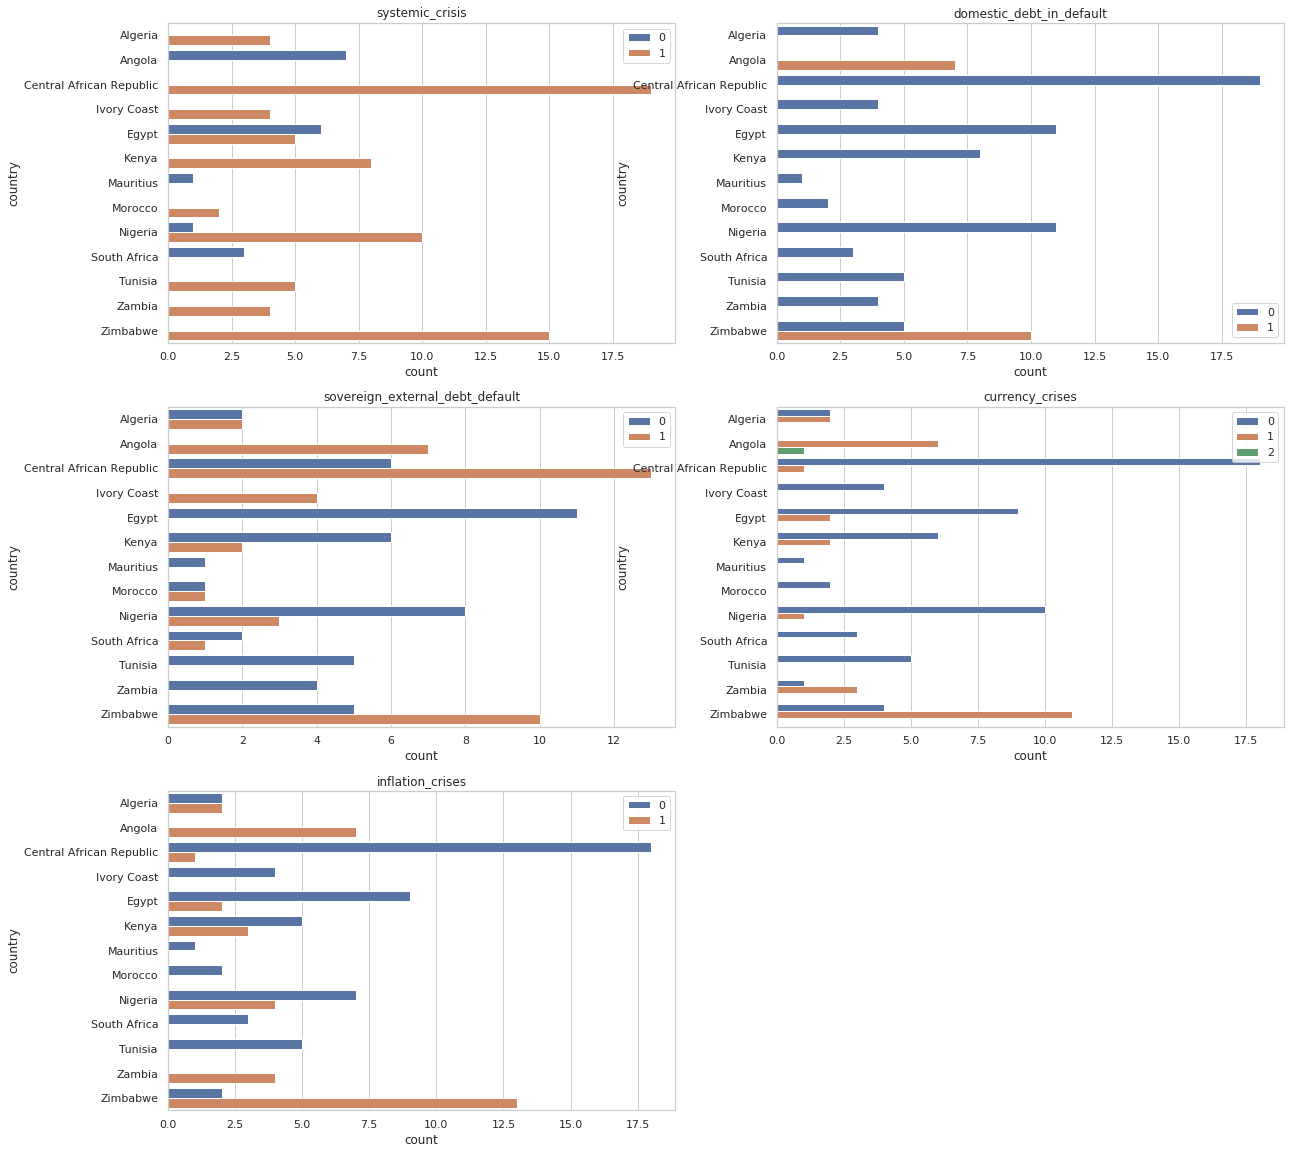

In [20]:
sns.set(style='whitegrid')
cols_countplot=['systemic_crisis','domestic_debt_in_default','sovereign_external_debt_default','currency_crises','inflation_crises']
plt.figure(figsize=(20,20))
count = 1
df_bank_crisis = df.loc[df['banking_crisis'] == 1]

for col in cols_countplot:
    plt.subplot(3,2,count)    
    count+= 1
    sns.countplot(y='country', hue = col, data = df_bank_crisis).set_title(col)    
    plt.legend(loc = 0)

The same can be done also when country didn't face a crisis.

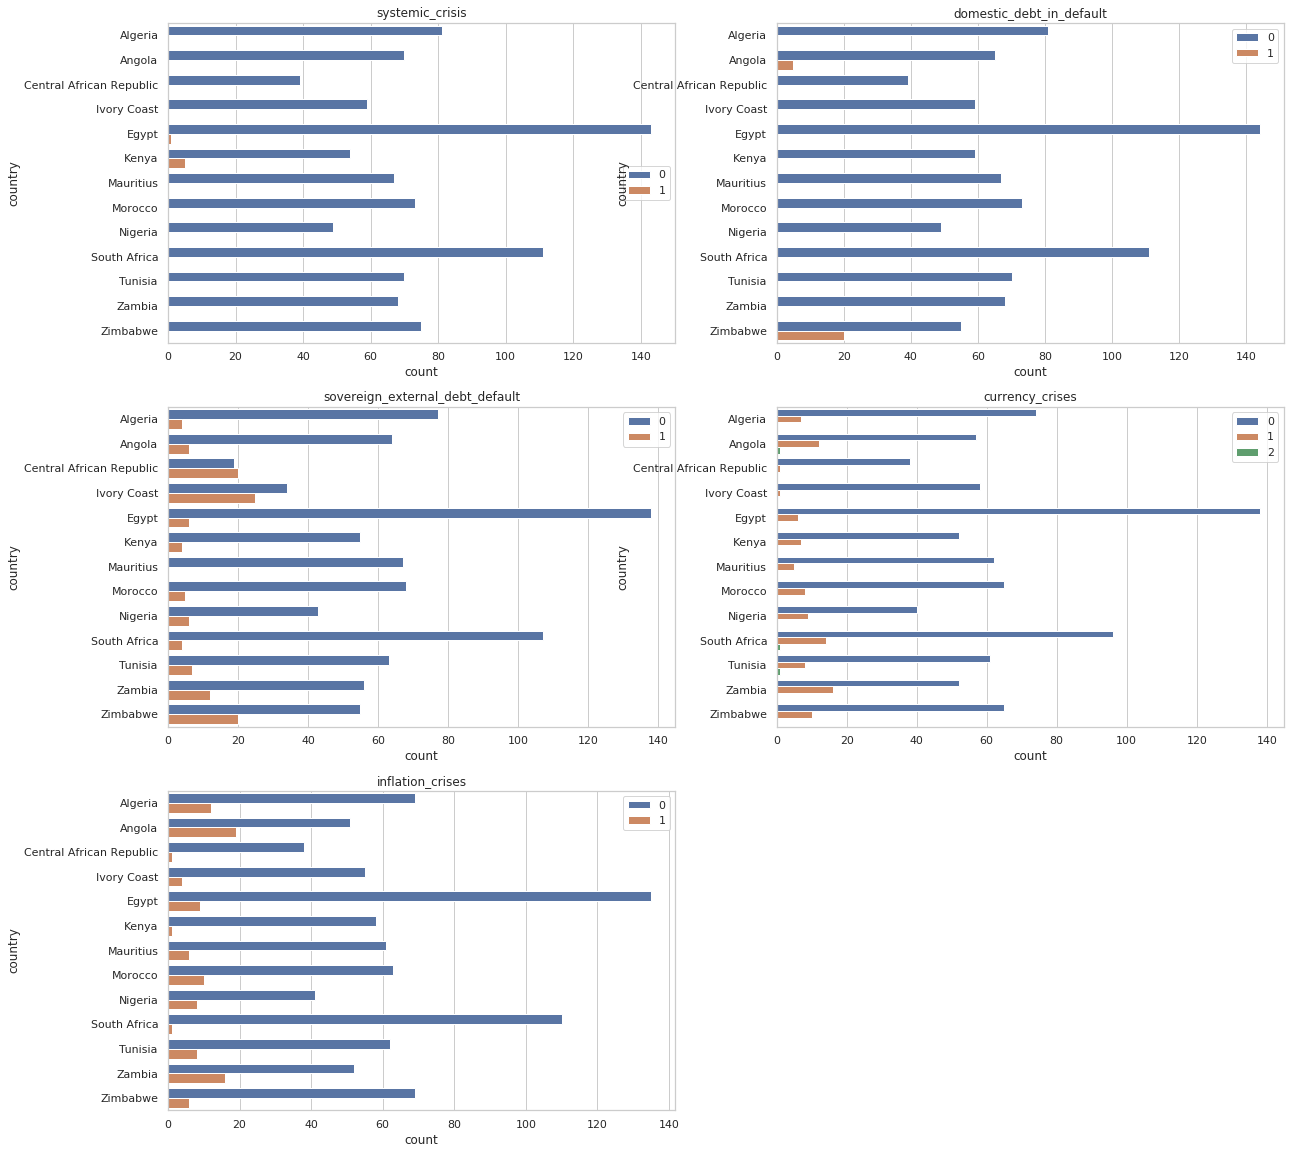

In [21]:
sns.set(style='whitegrid')
cols_countplot=['systemic_crisis','domestic_debt_in_default','sovereign_external_debt_default','currency_crises','inflation_crises']
plt.figure(figsize=(20,20))
count = 1
df_no_bank_crisis = df.loc[df['banking_crisis'] == 0]

for col in cols_countplot:
    plt.subplot(3,2,count)    
    count+= 1
    sns.countplot(y='country', hue = col, data = df_no_bank_crisis).set_title(col)    
    plt.legend(loc = 0)

Systemic crisis seems to be (not) occuring when banking crisis ( does not) occurs. Simoutaneosly, based just on these graphics I would assume that domestic debt in default has no effect at all on banking crisis whether it occurs or not. We should check this with a correlation matrix.

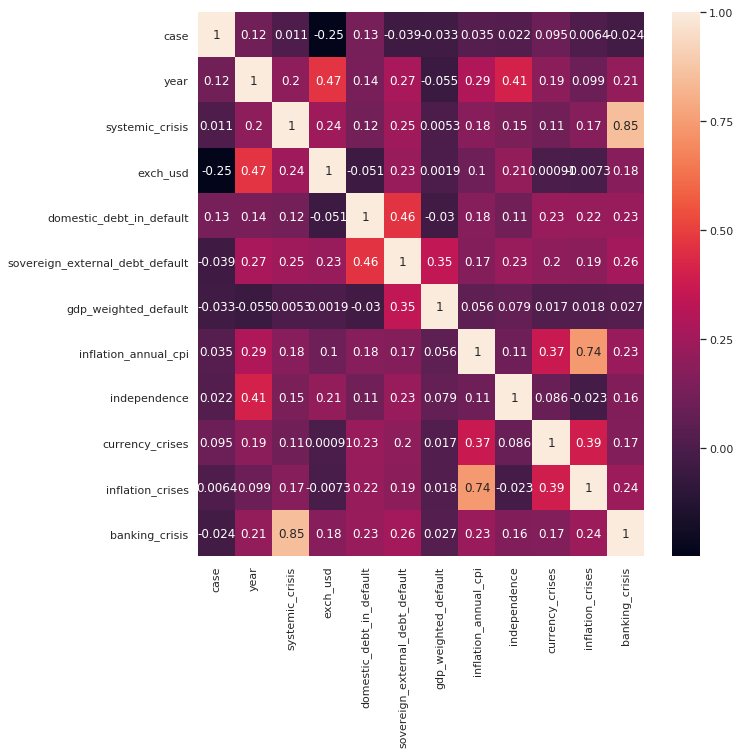

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)

Looking just on the banking crisis row we can see positive correlation between banking crisis and systemic crisis. This means when one of them appears the second one most probably follows. Investopedia also writes about relationship between systemic crisis and banking crisis (https://www.investopedia.com/terms/s/systemic-risk.asp)
Other indicators seem to have nor strong positive or negative correlation with the crisis.

**Modelling**

Let's run the data against several classification models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Keeping just relevant columns for dependent X variables and independent y variable

In [24]:
X = df.drop(['banking_crisis','cc3','country','year','case'], axis = 1)
y = df['banking_crisis'] 

Splitting columns for train and test samples

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

**Logistic regression**

*First I start with logistic regression as the basic technique for classifying binary data*

In [26]:
logistic_model = LogisticRegression()

In [27]:
logistic_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_predict_logm = logistic_model.predict(X_test)

Coefficients of the sigmoid function for logistic model

In [29]:
column_label = list(X_train.columns)
model_Coeff = pd.DataFrame(logistic_model.coef_, columns = column_label)
model_Coeff['intercept'] = logistic_model.intercept_
print("Coefficient Values Of The Surface Are: ", model_Coeff)

Coefficient Values Of The Surface Are:     systemic_crisis  exch_usd  domestic_debt_in_default  \
0         4.961856 -0.013591                  1.042746   

   sovereign_external_debt_default  gdp_weighted_default  \
0                         0.344039              0.218069   

   inflation_annual_cpi  independence  currency_crises  inflation_crises  \
0              0.034613      0.160256         0.192853          0.386993   

   intercept  
0  -3.982009  


When we run the score of the model we see that model achieves high number and thus have high explanatory power

In [30]:
logmodel_score = logistic_model.score(X_test,y_test)
print('Model score:\n', logmodel_score)

Model score:
 0.9842767295597484


In [31]:
print(metrics.confusion_matrix(y_test, y_predict_logm)) #22 = true positive, 291 = true negative, 2 = false positive, 3 = false negative

[[291   2]
 [  3  22]]


We get quite good results with logistic model (we don't have a robust sample therefore results show the model accuracy high)

In [32]:
print(classification_report(y_test,y_predict_logm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       293
           1       0.92      0.88      0.90        25

    accuracy                           0.98       318
   macro avg       0.95      0.94      0.94       318
weighted avg       0.98      0.98      0.98       318



**Decision tree**

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
decision_tree = DecisionTreeClassifier()

In [35]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [36]:
y_predict_tree = decision_tree.predict(X_test)

In [37]:
print(metrics.confusion_matrix(y_test, y_predict_tree))

[[283  10]
 [  4  21]]


In [38]:
print(classification_report(y_test,y_predict_tree))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       293
           1       0.68      0.84      0.75        25

    accuracy                           0.96       318
   macro avg       0.83      0.90      0.86       318
weighted avg       0.96      0.96      0.96       318



Compared to logistic model, decision tree model show lower results.

In [39]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list( df.drop(['banking_crisis','cc3','country','year','case'], axis = 1))

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


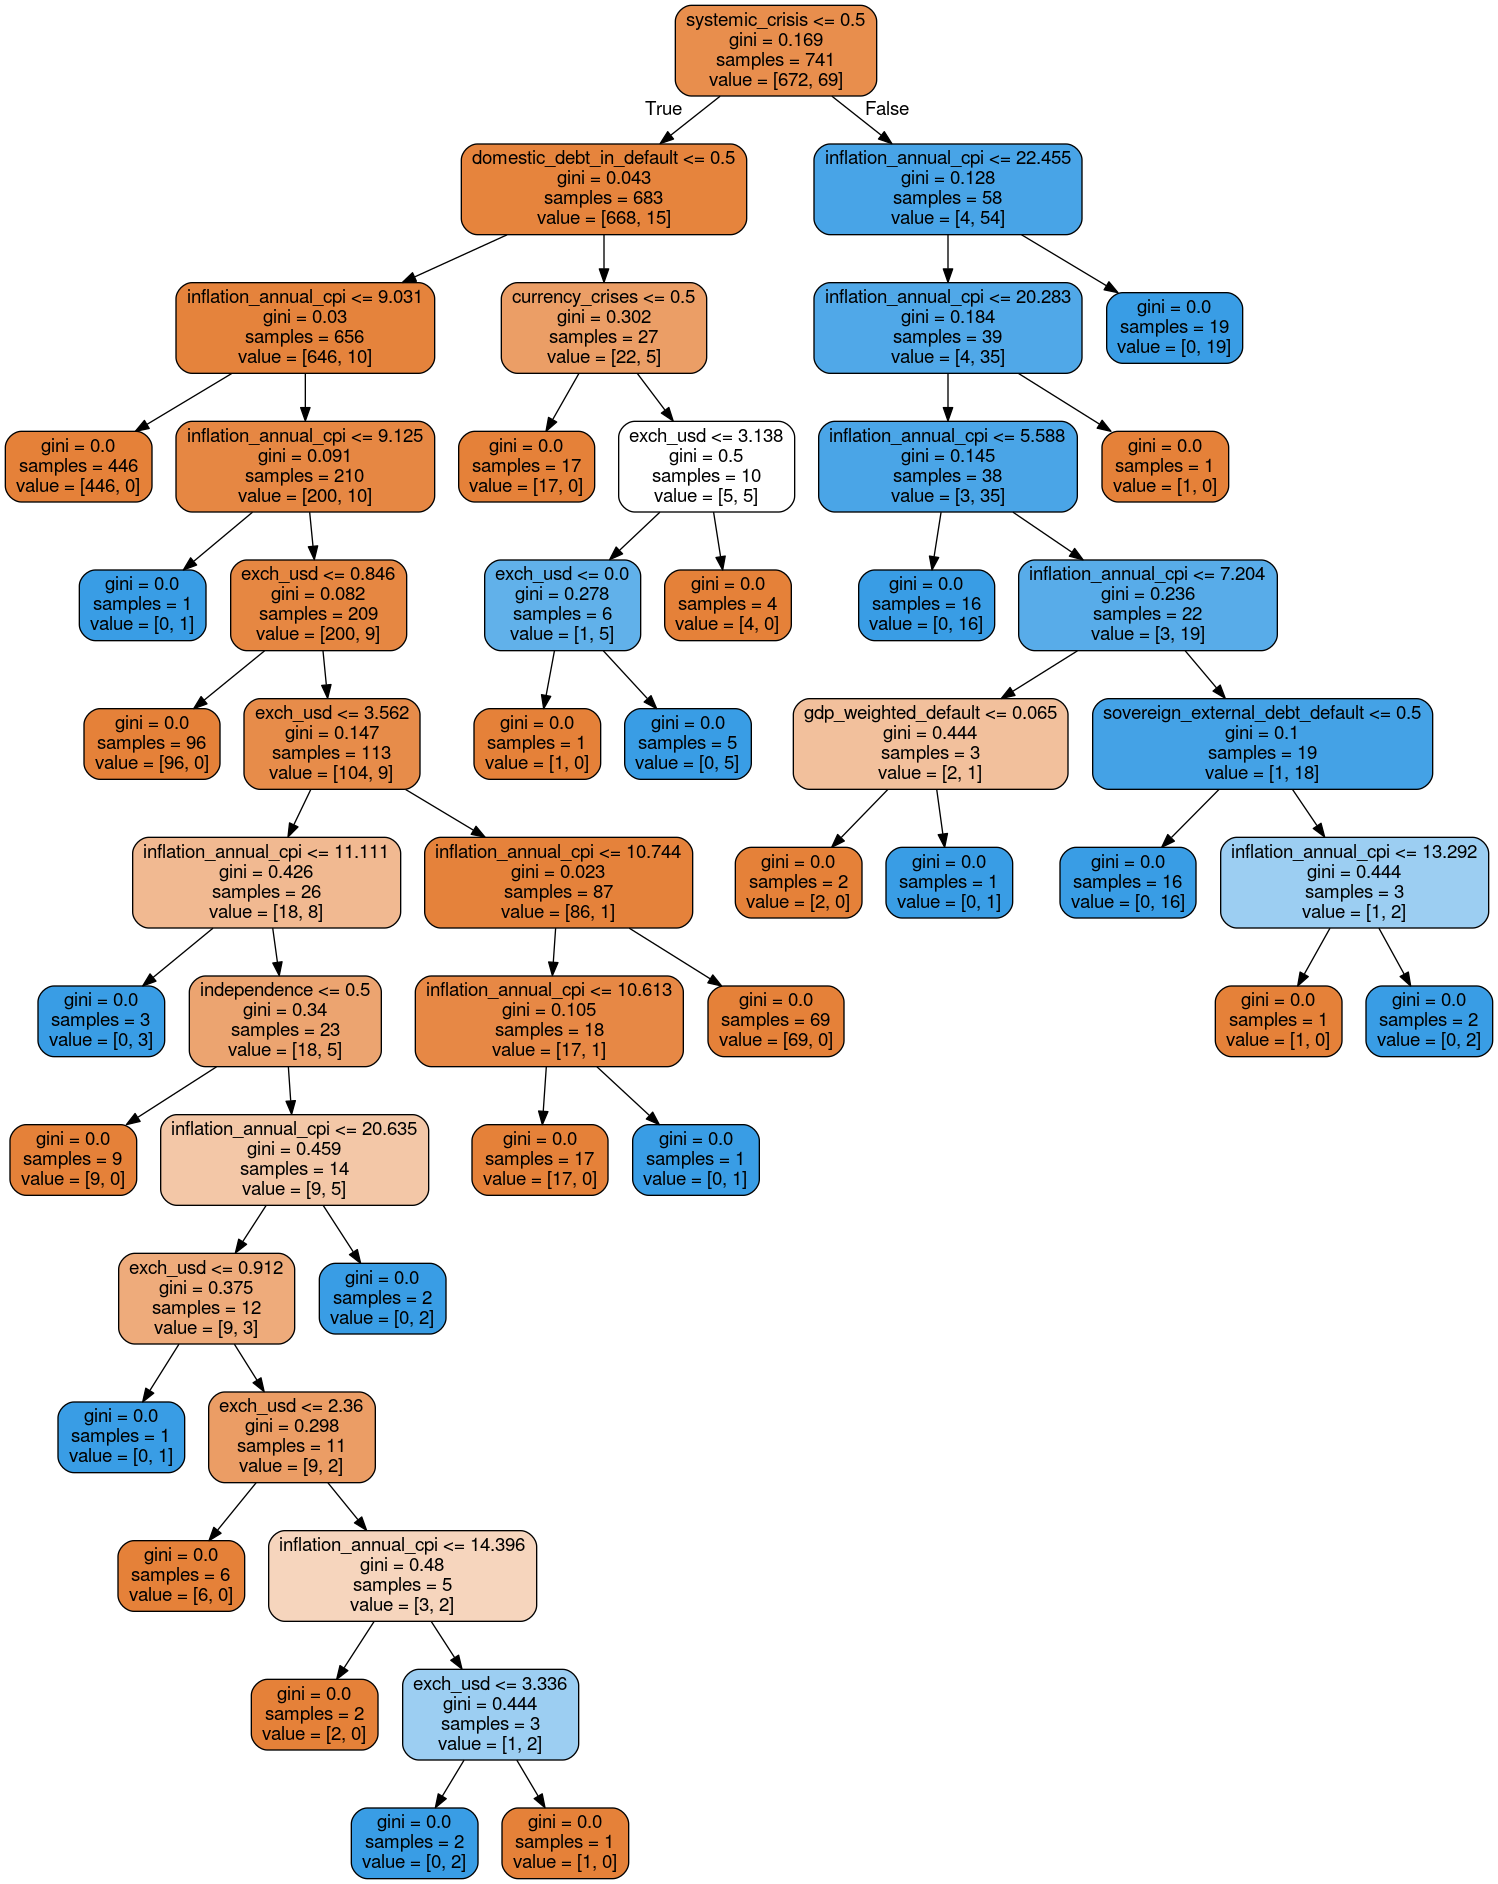

In [40]:
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

We can see that splitting happens with relativily low Gini coefficients (majority of values belongs to one class, if the division would be even we would 0.5 Gini index)

**Random Forests**

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
rfc_pred = rfc.predict(X_test)

In [43]:
print(confusion_matrix(y_test,rfc_pred))

[[292   1]
 [  2  23]]


In [44]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       293
           1       0.96      0.92      0.94        25

    accuracy                           0.99       318
   macro avg       0.98      0.96      0.97       318
weighted avg       0.99      0.99      0.99       318



When applying Random tree on the dataset we receive very good results.

**SVM**

In [45]:
from sklearn.svm import SVC

In [46]:
svc_model = SVC() #with predefined parameters

In [47]:
svc_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [48]:
svm_pred = svc_model.predict(X_test)

In [49]:
print(confusion_matrix(y_test,svm_pred))

[[292   1]
 [ 12  13]]


In [50]:
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       293
           1       0.93      0.52      0.67        25

    accuracy                           0.96       318
   macro avg       0.94      0.76      0.82       318
weighted avg       0.96      0.96      0.95       318



We've got quite good results with predefined parameters

We can search for the best parameters with the help of Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [53]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.8s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

*Best parameters*

In [54]:
grid.best_params_ 

{'C': 100, 'gamma': 0.01}

We run again the model with parameters we found as best in the grid search 

In [55]:
grid_pred = grid.predict(X_test)

In [56]:
print(confusion_matrix(y_test,grid_pred))

[[292   1]
 [  2  23]]


In [57]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       293
           1       0.96      0.92      0.94        25

    accuracy                           0.99       318
   macro avg       0.98      0.96      0.97       318
weighted avg       0.99      0.99      0.99       318



We can see improvement in results with new parameters and work with SVM as suitable modelling approach for this dataset

**K Means clustering**

In [58]:
from sklearn.cluster import KMeans

In [59]:
kmeans = KMeans(n_clusters=2)

In [60]:
kmeans.fit(df.drop(['banking_crisis','cc3','country','year','case'], axis = 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [61]:
kmeans.cluster_centers_

array([[3.91198044e-02, 1.88531901e+00, 4.15647922e-02, 1.05134474e-01,
        6.52811736e-03, 7.06554297e+00, 7.33496333e-01, 1.30806846e-01,
        1.25916870e-01],
       [2.07468880e-01, 2.02142083e+01, 3.31950207e-02, 3.15352697e-01,
        5.97510373e-03, 9.39663904e+00, 9.21161826e-01, 1.36929461e-01,
        1.41078838e-01]])

In [62]:
df['Cluster'] = df['banking_crisis']

In [63]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(df['Cluster'],kmeans.labels_))
print(classification_report(df['Cluster'],kmeans.labels_))

[[771 194]
 [ 47  47]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       965
           1       0.20      0.50      0.28        94

    accuracy                           0.77      1059
   macro avg       0.57      0.65      0.57      1059
weighted avg       0.88      0.77      0.81      1059



Without any futher data manipulation applying K-means (cluster) model on the dataset results in poor numbers for precision, recall f1-score and accuracy. Model isn't suitable in this setting.

*When I compare above models, SVM with adjusted parameters (C:100, gamma :0.01) performs the best for the dataset. Simoutaneosly, random forests and logistic regression can be also used without modifications. Remaining models would need more feature engineering in order to improve their results*